idea:
sample the random parameters from distribution & solve the corresponding LP - repeat multiple times (monte carlo simulation...)


How to handle the binary variable x4? As it is only one, run a loop with x4=0 and one with x4=1 for each monte-carlo sampling step.

In [1]:
from scipy.optimize import linprog
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import numpy as np

## 1) test sampling from distributions
random sample x3 (uniform dist)

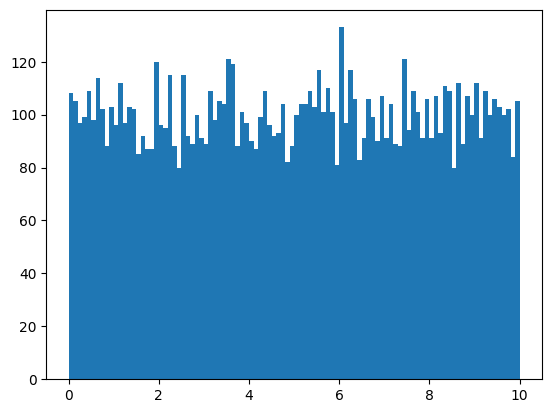

In [2]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = np.random.uniform(0,10)
plt.hist(val,bins=100);

random sample from gamma dist

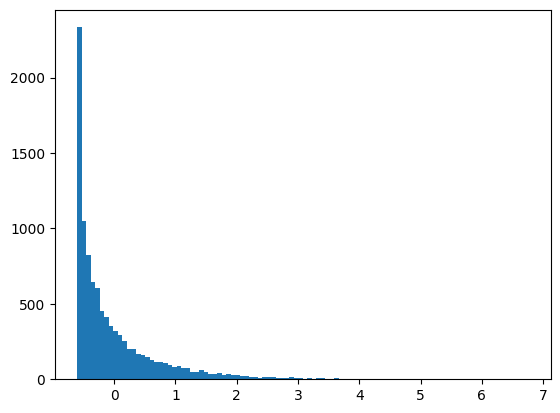

In [3]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = gamma.rvs(0.6,scale=1)-0.6
plt.hist(val,bins=100);

random sample from R distribution (combine uniform dist for x3 and gamma dist)

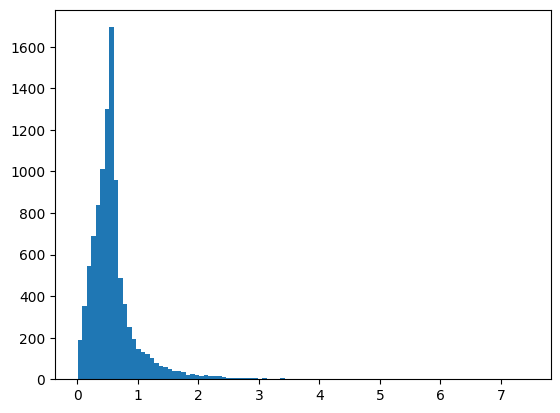

In [4]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    x3 = np.random.uniform(0,10)
    val[i] = 0.6 + (gamma.rvs(0.6,scale=1)-0.6)*(1-x3/10)
plt.hist(val,bins=100);

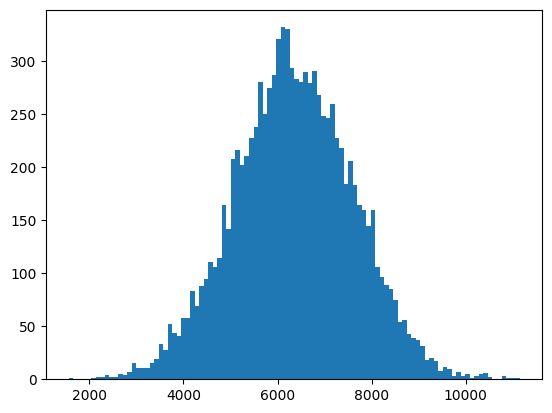

In [5]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = norm.rvs(6350,scale=1270)
plt.hist(val,bins=100);

## 2) implement optimization with monte-carlo sampling

x3, R & C are sampled randomly

for each sample, the optimization problem is solved for x4=0 & x4=1.

In [6]:
N_mc = 10000
num_rep = 1
opt_profit_rep = np.zeros(num_rep)
opt_sol_rep=np.zeros((num_rep,4))
for rep in range(0,num_rep):
    opt_sol=np.zeros((N_mc,4))
    opt_profit=np.zeros(N_mc)
    cnt=0
    opt_rand_var=np.zeros((N_mc,2))

    for i in range(0,N_mc):
        R_rand0 = (gamma.rvs(0.6,scale=1)-0.6)
        C_rand0 = norm.rvs(6350,scale=1270)
        # test (solve) this sample for different x3&x4 choices (brute force)
        cnt_inner = 0
        N_x3=100
        N_inner = N_x3*2
        opt_sol_inner = np.zeros((N_inner,4))
        opt_profit_inner = np.zeros(N_inner)
        opt_rand_var_inner = np.zeros((N_inner,2))
        for x3_ in range(0,N_x3):
            x3=x3_/(N_x3/10)
            for x4 in range(0,2):
                R_rand = 0.6+R_rand0*(1-x3/10)
                C_rand = np.max((C_rand0,5200*x4))

                objective = [-250,-300]
                lhs_ineq = [[0.4,R_rand],
                            [3,2.5],
                            [1.27,1.27]]
                rhs_ineq = [[2500],
                            [14000],
                            [C_rand]]

                bnd = [ (0, float("inf")),
                        (0, float("inf"))]
                opt = linprog(c=objective, A_ub=lhs_ineq, b_ub=rhs_ineq,bounds=bnd,method="highs")

                opt_sol_inner[cnt_inner,:] = np.concatenate((opt.x, [x3], [x4]))
                opt_profit_inner[cnt_inner] = opt.fun*-1 - 470*x3 - 30e3*x4
                opt_rand_var_inner[cnt_inner,:] = np.array([R_rand,C_rand])
                cnt_inner +=1
        idx=np.argmax(opt_profit_inner)

        opt_sol[cnt,:] = opt_sol_inner[idx,:]
        opt_profit[cnt] = opt_profit_inner[idx]
        opt_rand_var[cnt,:] = opt_rand_var_inner[idx,:]
        cnt +=1

In [7]:
avg_profit = np.mean(opt_profit)
avg_opt_sol = np.mean(opt_sol,axis=0)
avg_opt_sol[3]=np.round(avg_opt_sol[3])
print("Average profit: ", avg_profit,'$')
print("Average optimal solution: [x1,x2,x3,x4] = ", avg_opt_sol)

Average profit:  1415529.6358128926 $
Average optimal solution: [x1,x2,x3,x4] =  [6.76347331e+02 4.17596477e+03 3.29070000e+00 0.00000000e+00]


check distribution of R&C

Text(0.5, 1.0, 'Distribution of R')

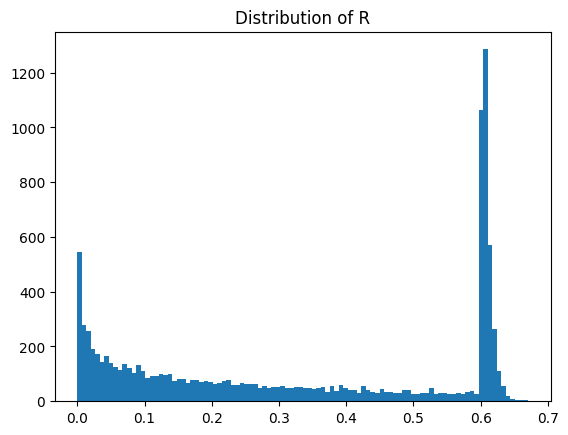

In [8]:
plt.hist(opt_rand_var[:,0],bins=100);
plt.title('Distribution of R')

Text(0.5, 1.0, 'Distribution of C')

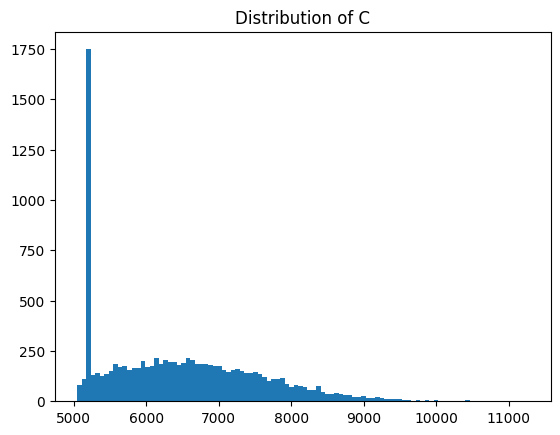

In [9]:
plt.hist(opt_rand_var[:,1],bins=100);
plt.title('Distribution of C')